# Prerequisites & Setup

In [31]:
#!pip install --upgrade py2neo
#!pip install matplotlib
import operator
import pandas
pandas.set_option('display.max_rows', 100)
from py2neo import Graph
graph = Graph(password="do-not-type-your-password-here")

# Graph Analytics
## What is in the graph?

In [16]:
query="match (n) where exists(n.type) return n.type, count(n)"
data_frame=graph.run(query).to_data_frame()
data_frame

,n.type,count(n)
0,publication,242557
1,researcher,54394
2,organisation,50013
3,dataset,1853


In [17]:
query="match (n)-[r]-(m) where exists(n.type) and exists(m.type) return n.type,m.type, count(r)"
data_frame=graph.run(query).to_data_frame()
data_frame

,n.type,m.type,count(r)
0,publication,publication,184524
1,researcher,publication,201527
2,publication,researcher,201527
3,organisation,researcher,161463
4,researcher,organisation,161463
5,dataset,researcher,172
6,researcher,dataset,172
7,publication,dataset,39
8,dataset,publication,39


## Number of publications

In [18]:
query="match (p:crossref) return p.title, p.doi, p.crossref_issue limit 1"
data_frame=graph.run(query).to_data_frame()
data_frame

,p.title,p.doi,p.crossref_issue
0,Générer des données d’essais randomisés pour o...,10.1503/cmaj.200438-f,None


In [19]:
query="match (p:crossref:publication) return left(p.crossref_issued,4) as year, count(p) as count order by year DESC limit 15"
data_frame=graph.run(query).to_data_frame()
data_frame

,year,count
0,None,1067
1,2021,1387
2,2020,140550
3,2019,600
4,2018,406
5,2017,360
6,2016,422
7,2015,366
8,2014,367
9,2013,344


### 2020 Publications

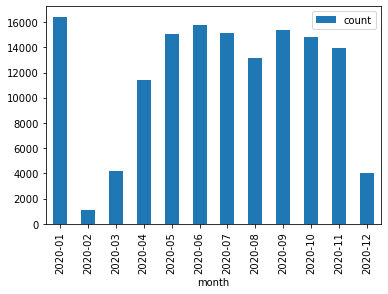

In [20]:
query="match (p:crossref:publication) where p.publication_year = '2020' return p.graph_entry_month as month, count(p) as count order by month"
data_frame=graph.run(query).to_data_frame()
data_frame.plot.bar(x="month", y="count")

### 2021 Publications

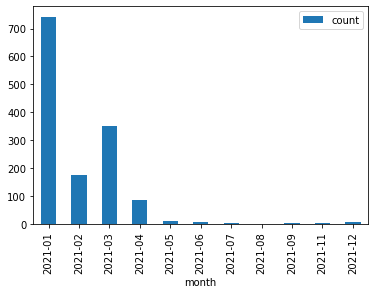

In [22]:
query="match (p:crossref:publication) where p.publication_year = '2021' return p.graph_entry_month as month, count(p) as count order by month"
data_frame=graph.run(query).to_data_frame()
data_frame.plot.bar(x="month", y="count")

### Finding collaboration links to the University of Melbourne 

In [23]:
query="match (org:orcid:organisation) where org.name='University of Melbourne' return org.key"
key1=graph.run(query).evaluate()

query="match (org1:organisation)--(r1:researcher)--(p:publication)--(r2:researcher)--(org2:organisation) where org1.key='{}' and org1<>org2 return org2.name as Organisation, count(p) as Joint_Publications order by Joint_Publications DESC".format(key1)
data_frame=graph.run(query).to_data_frame()
data_frame

,Organisation,Joint_Publications
0,Monash University,142
1,University of Oxford,99
2,Australian National University,53
3,London School of Hygiene & Tropical Medicine,52
4,University of Queensland,52
...,...,...
1602,US Food and Drug Administration,1
1603,NIH,1
1604,L. Sacco Hospital,1
1605,University of Catania,1


### Number of organisations collaborating with Australian Universities

In [24]:
query="""match (org1:organisation)-[r1]-(orcid1:orcid:researcher)-[r2]-(doi:publication)-[r3]-(orcid2:orcid:researcher)-[r4]-(org2:organisation) 
where org1.country=\"AU\" and exists(org2.country)
return org2.country as Country, count(distinct(org2)) as Number_Organisations order by Number_Organisations DESC limit 10 """
data_frame=graph.run(query).to_data_frame()
data_frame

,Country,Number_Organisations
0,US,730
1,AU,680
2,GB,666
3,ES,314
4,DE,257
5,IT,253
6,IN,214
7,CN,197
8,FR,167
9,BD,123


In [28]:
query="""match (org1:organisation)-[r1]-(orcid1:orcid:researcher)-[r2]-(doi:publication)-[r3]-(orcid2:orcid:researcher)-[r4]-(org2:organisation) 
where org1.country=\"IN\" and exists(org2.country)
return org2.country as Country, count(distinct(org2)) as Number_Organisations order by Number_Organisations DESC limit 10 """
data_frame=graph.run(query).to_data_frame()
data_frame

,Country,Number_Organisations
0,IN,2326
1,US,898
2,GB,496
3,ES,210
4,IT,201
5,DE,184
6,AU,132
7,FR,120
8,CN,106
9,BD,97


In [37]:
query="match (org:organisation) where org.graph_entry_month<='2009-12' return count(distinct(org))"
print(graph.run(query).evaluate())

1685


# Export Graphs

In [30]:
cmd="""call apoc.export.graphml.query('
match (org1:organisation)-[r1]-(orcid1:orcid:researcher)-[r2]-(doi:publication)-[r3]-(orcid2:orcid:researcher)-[r4]-(org2:organisation) 
where org1.country=\"AU\" 
return org1,org2,orcid1,orcid2,doi,
r1,r2,r3,r4',
'AU-Graph.graphml',
{})"""
graph.run(cmd)

 file             | source                               | format  | nodes | relationships | properties | time |  rows | batchSize | batches | done | data 
------------------|--------------------------------------|---------|-------|---------------|------------|------|-------|-----------|---------|------|------
 AU-Graph.graphml | statement: nodes(11952), rels(20401) | graphml | 11952 |         20401 |     197627 | 1040 | 32353 |        -1 |       0 | true | null 

In [44]:
cmd="""call apoc.export.graphml.query('
match (org1:organisation)-[r1]-(orcid1:orcid:researcher)-[r2]-(doi:publication)-[r3]-(orcid2:orcid:researcher)-[r4]-(org2:organisation) 
where org1.country=\"US\" 
return org1,org2,orcid1,orcid2,doi,
r1,r2,r3,r4',
'US-Graph.graphml',
{})"""
graph.run(cmd)

 file             | source                               | format  | nodes | relationships | properties | time |   rows | batchSize | batches | done | data 
------------------|--------------------------------------|---------|-------|---------------|------------|------|--------|-----------|---------|------|------
 US-Graph.graphml | statement: nodes(42136), rels(81740) | graphml | 42136 |         81740 |     751328 | 1959 | 123876 |        -1 |       0 | true | null 